# **Import and preprocessing**

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [23]:
#Import dataset and set sort ascending index "Date"
df = pd.read_csv("/content/HPG Historical Data.csv", parse_dates=['Date'], index_col='Date', sep=';')
df = df.sort_index(ascending=True)
print(df.head())

             Price    Open    High     Low    Vol. Change %
Date                                                       
2019-03-01  12.054  11.825  12.054  11.825  12.62M    1,93%
2019-03-04  12.441  12.230  12.441  12.212  13.74M    3,21%
2019-03-05  12.335  12.353  12.529  12.300  15.62M   -0,85%
2019-03-06  12.318  12.318  12.388  12.107   9.24M   -0,14%
2019-03-07  12.001  12.318  12.335  12.001  12.47M   -2,57%


In [24]:
#Read type of dataset
print(df.dtypes)

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [25]:
#Preprocessing dataset - Change % and Vol.
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1e6

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,12.054,11.825,12.054,11.825,12620000.0,0.0193
2019-03-04,12.441,12.230,12.441,12.212,13740000.0,0.0321
2019-03-05,12.335,12.353,12.529,12.300,15620000.0,-0.0085
2019-03-06,12.318,12.318,12.388,12.107,9240000.0,-0.0014
2019-03-07,12.001,12.318,12.335,12.001,12470000.0,-0.0257


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998782  0.999483  0.999430  0.433287  0.016169
Open      0.998782  1.000000  0.999483  0.999466  0.431231 -0.025500
High      0.999483  0.999483  1.000000  0.999338  0.441149 -0.005920
Low       0.999430  0.999466  0.999338  1.000000  0.422579 -0.005855
Vol.      0.433287  0.431231  0.441149  0.422579  1.000000  0.011799
Change %  0.016169 -0.025500 -0.005920 -0.005855  0.011799  1.000000


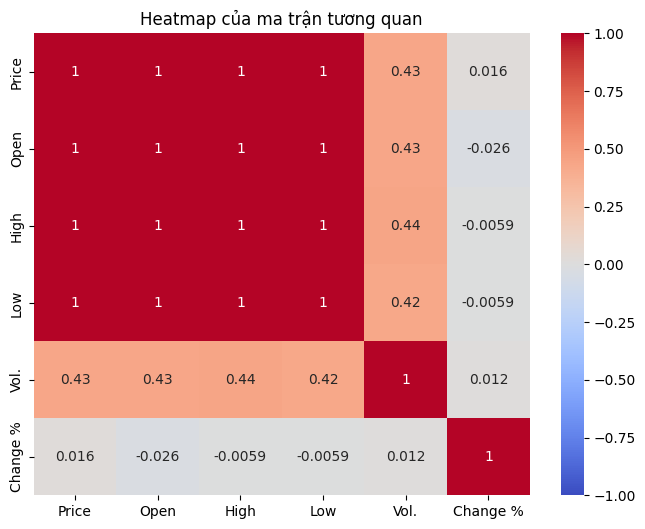

In [26]:
#Find best features for VARMA model by evaluate each features using heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [27]:
#Choose best features from heatmap
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,12.054,11.825,12.054,11.825
2019-03-04,12.441,12.230,12.441,12.212
2019-03-05,12.335,12.353,12.529,12.300
2019-03-06,12.318,12.318,12.388,12.107
2019-03-07,12.001,12.318,12.335,12.001


# **Split train, test by 90:10**

In [28]:
#Split train and test by 9:1
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1252
1126
126


In [29]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.17977e-30): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.89653e-31): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likeliho

VARMA(1, 1) - AIC: 56820.752947970475


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.17977e-30): result may not be accurate.
  x = solve(lhs, q.flatten())


VARMA(1, 2) - Error: Schur decomposition solver error.
VARMA(1, 3) - Error: 2-th leading minor of the array is not positive definite
VARMA(1, 4) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 1) - Error: 2-th leading minor of the array is not positive definite
VARMA(2, 2) - Error: 2-th leading minor of the array is not positive definite
VARMA(2, 3) - Error: 2-th leading minor of the array is not positive definite
VARMA(2, 4) - Error: 2-th leading minor of the array is not positive definite
VARMA(3, 1) - Error: 1-th leading minor of the array is not positive definite
VARMA(3, 2) - Error: 1-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.17977e-30): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10

VARMA(3, 3) - Error: 1-th leading minor of the array is not positive definite
VARMA(3, 4) - Error: 1-th leading minor of the array is not positive definite
VARMA(4, 1) - Error: 2-th leading minor of the array is not positive definite
VARMA(4, 2) - Error: 2-th leading minor of the array is not positive definite
VARMA(4, 3) - Error: 2-th leading minor of the array is not positive definite
VARMA(4, 4) - Error: 2-th leading minor of the array is not positive definite
Best VARMA order: (1, 1) - AIC: 56820.752947970475


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecas

In [30]:
#Create model and training
model = VARMAX(train, order=(1, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1126
Model:                           VARMA(1,1)   Log Likelihood                  66.772
                                + intercept   AIC                            -41.544
Date:                      Sun, 09 Jun 2024   BIC                            189.671
Time:                              06:52:02   HQIC                            45.826
Sample:                                   0                                         
                                     - 1126                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):     0.01, 0.00, 0.06, 0.00   Jarque-Bera (JB):   489.00, 10626.52, 1831.26, 1011.54
Prob(Q):                0.91, 0.99, 0.81, 0.97   Prob(JB):                       0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 6.9

In [31]:
#Forecast test dataset
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                Price       Open       High        Low
Date                                                  
2023-08-29  26.863785  26.953298  27.266261  26.608225
2023-08-30  26.857487  26.896610  27.250578  26.530707
2023-08-31  26.849216  26.895667  27.254425  26.517426
2023-09-05  26.840352  26.886954  27.249055  26.504200
2023-09-06  26.831259  26.878146  27.241462  26.493552


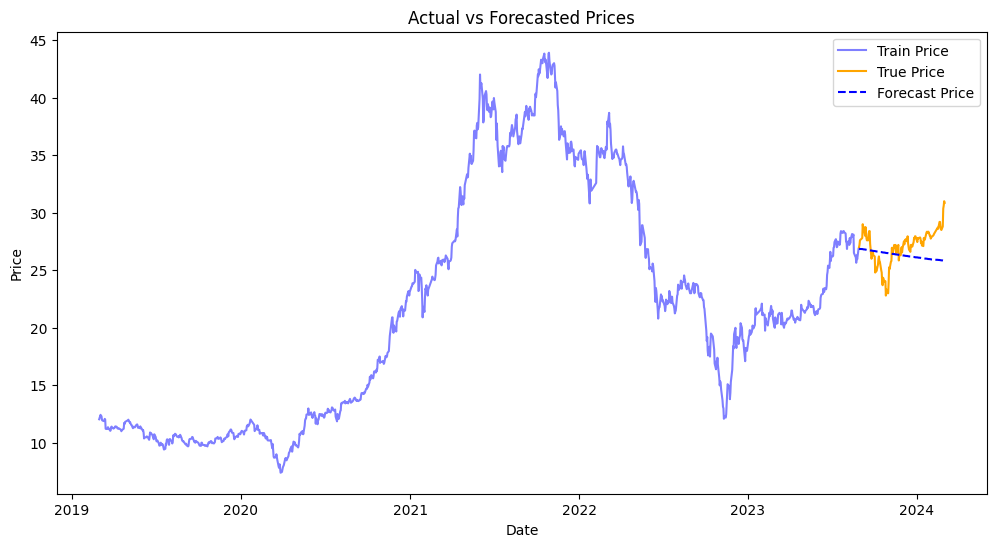

In [32]:
#Visualize result into plt for better understading
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)

plt.plot(test.index, test["Price"], label='True Price', color='orange')

plt.plot(test.index, forecast["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Split train, test by 8:2**

In [33]:
#Split train and test by 8:2
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1252
1001
251


In [34]:
model = VARMAX(train, order=(1, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1001
Model:                           VARMA(1,1)   Log Likelihood                 -23.740
                                + intercept   AIC                            139.480
Date:                      Sun, 09 Jun 2024   BIC                            365.283
Time:                              06:52:12   HQIC                           225.297
Sample:                                   0                                         
                                     - 1001                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):      0.02, 0.01, 0.06, 0.00   Jarque-Bera (JB):   408.12, 8549.24, 1589.00, 866.68
Prob(Q):                 0.89, 0.93, 0.81, 1.00   Prob(JB):                     0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H): 9.63,

In [35]:
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                Price       Open       High        Low
Date                                                  
2023-03-02  20.871594  20.988478  21.272684  20.631859
2023-03-03  20.870088  20.885737  21.202713  20.569386
2023-03-06  20.870364  20.893345  21.200229  20.585038
2023-03-07  20.870972  20.892719  21.197222  20.588394
2023-03-08  20.871710  20.893373  21.196681  20.590649


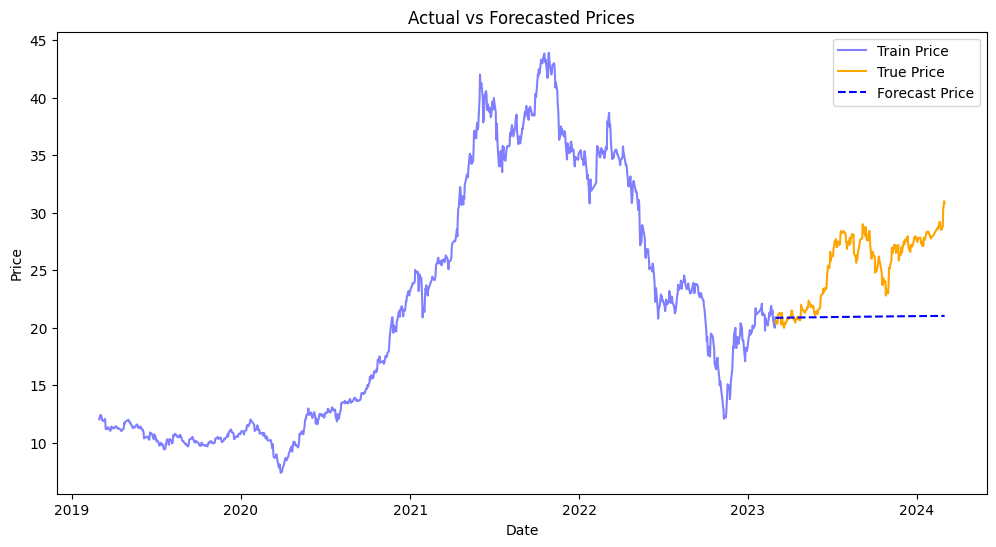

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)

plt.plot(test.index, test["Price"], label='True Price', color='orange')

plt.plot(test.index, forecast["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Split train, test by 7:3**

In [40]:
#Split train and test by 7:3
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1252
876
376


In [41]:
model = VARMAX(train, order=(1, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                  876
Model:                           VARMA(1,1)   Log Likelihood                  84.021
                                + intercept   AIC                            -76.041
Date:                      Sun, 09 Jun 2024   BIC                            143.626
Time:                              06:53:06   HQIC                             7.982
Sample:                                   0                                         
                                      - 876                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):        0.02, 0.03, 0.03, 0.00   Jarque-Bera (JB):   585.96, 9919.96, 2308.76, 1063.30
Prob(Q):                   0.90, 0.85, 0.87, 0.97   Prob(JB):                      0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):

In [42]:
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                Price       Open       High        Low
Date                                                  
2022-08-29  23.493234  23.509192  23.837769  23.174872
2022-08-30  23.488231  23.520968  23.840383  23.194769
2022-08-31  23.484867  23.514632  23.833825  23.191764
2022-09-05  23.481738  23.511516  23.829943  23.189752
2022-09-06  23.478704  23.508395  23.826541  23.187100


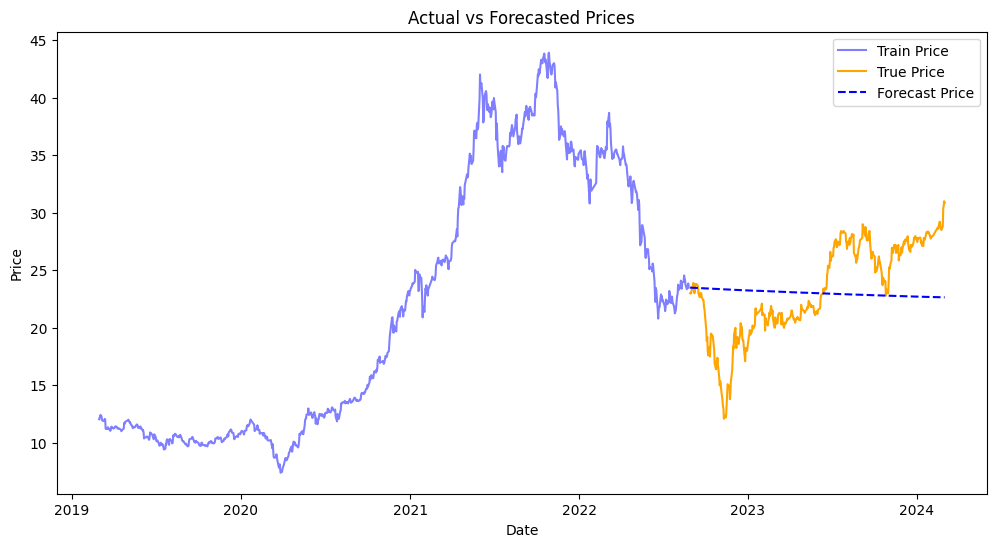

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)

plt.plot(test.index, test["Price"], label='True Price', color='orange')

plt.plot(test.index, forecast["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**MAE, MAPE, RMSE**

In [44]:
#Determine MEAN and MAPE, RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 3.6969145592552213
Mean Absolute Percentage Error (MAPE): 0.17060912091821487
Root Mean Squared Error (RMSE): 4.304263799306023


# **Forecast next 30,60,90 days**

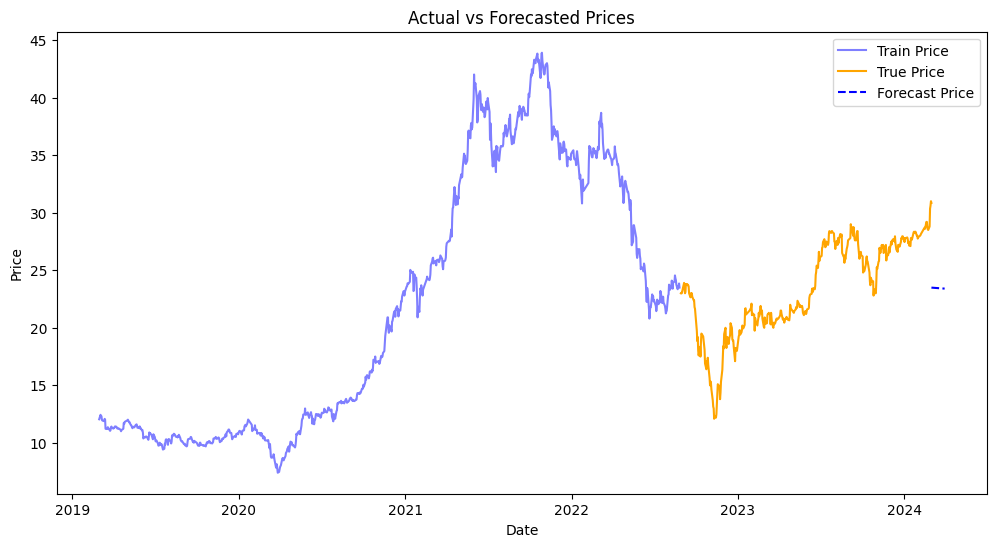

In [45]:
forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


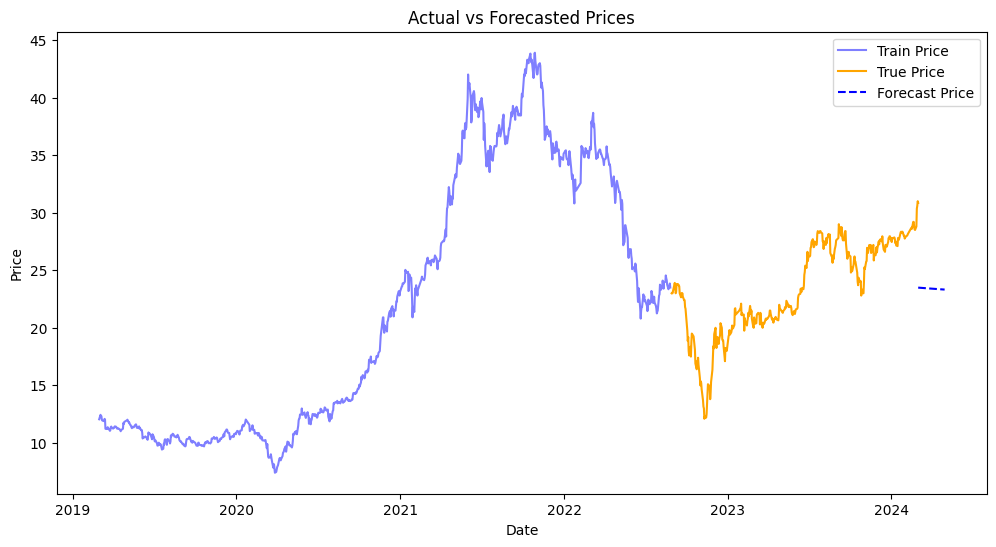

In [46]:
forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

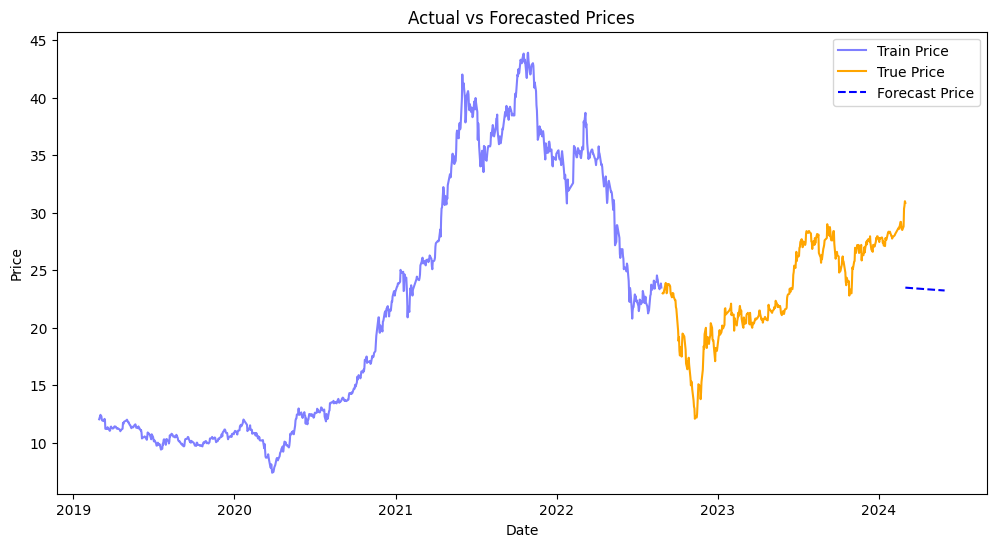

In [47]:
forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)

# Create a dataframe for the forecasted values
# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)
# Plot the forecasted values
plt.figure(figsize=(12, 6))

plt.plot(train_df.index, train_df["Price"], label='Train Price', color='blue', alpha=0.5)
plt.plot(test.index, test["Price"], label='True Price', color='orange')
plt.plot(forecast_df.index, forecast_df["Price"], label='Forecast Price', linestyle='--', color='blue')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()